<a href="https://colab.research.google.com/github/Sunsi13/Andoid/blob/master/handGesture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import des différents modules

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import keras
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from keras.layers import Conv2D, Activation, MaxPool2D, Dense, Flatten, Dropout

In [ ]:
CATEGORIES = ["01_palm", '02_l','03_fist','04_fist_moved','05_thumb','06_index','07_ok','08_palm_moved','09_c','10_down']
IMG_SIZE = 50

# paths for dataset
data_path = r"C:\Users\diall\Downloads\rqpport\archive\leapGestRecog"

In [ ]:
accès aux fichiers stockés sur Google Drive directement depuis Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


unzip du fichier de données a traité

In [ ]:
!unzip "/content/drive/My Drive/hand/archive.zip"


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0012.png  
  inflatin

Import des différents modules

In [ ]:
import os
import warnings
import cv2
import keras
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
from PIL import Image
from keras import models, layers, optimizers
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, Dropout, Flatten
from keras.models import Model
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from tensorflow.keras.optimizers import SGD


 renommés les données sur la base des deux caractères du nom du geste afin de préparer les images et son étiquette de geste correspondante pour les données .

In [ ]:
def rename_file_based_parent_dir(path):
    for directory, subdirectories, files in os.walk(path):
        print(directory)
        print(os.listdir(os.path.abspath(directory)))
        if os.listdir(os.path.abspath(directory)) == []:
            continue
        else:
            if (os.path.isdir(directory)) and len(os.listdir(directory)) >= 11:
                for file in os.listdir(directory):
                    prefix = os.path.basename(directory).split('_')[1][0:2]

                    new_name = os.path.join(os.path.abspath(directory), prefix + os.path.basename(file))

                    os.rename(os.path.join(directory, file), new_name)

rename_file_based_parent_dir('/content/leapGestRecog')

/content/leapGestRecog
['05', '02', '09', '06', '07', '01', '00', '08', '03', '04']
/content/leapGestRecog/05
['05_thumb', '04_fist_moved', '07_ok', '09_c', '10_down', '08_palm_moved', '01_palm', '03_fist', '06_index', '02_l']
/content/leapGestRecog/05/05_thumb
['frame_05_05_0051.png', 'frame_05_05_0191.png', 'frame_05_05_0096.png', 'frame_05_05_0008.png', 'frame_05_05_0175.png', 'frame_05_05_0107.png', 'frame_05_05_0001.png', 'frame_05_05_0137.png', 'frame_05_05_0172.png', 'frame_05_05_0032.png', 'frame_05_05_0062.png', 'frame_05_05_0022.png', 'frame_05_05_0198.png', 'frame_05_05_0196.png', 'frame_05_05_0171.png', 'frame_05_05_0139.png', 'frame_05_05_0010.png', 'frame_05_05_0060.png', 'frame_05_05_0018.png', 'frame_05_05_0071.png', 'frame_05_05_0165.png', 'frame_05_05_0118.png', 'frame_05_05_0136.png', 'frame_05_05_0028.png', 'frame_05_05_0088.png', 'frame_05_05_0074.png', 'frame_05_05_0005.png', 'frame_05_05_0014.png', 'frame_05_05_0143.png', 'frame_05_05_0192.png', 'frame_05_05_0120

Prétraitement des données Cette section contient le bloc principal de code qui crée des métadonnées et effectue le prétraitement complet de 20 000 data.

In [ ]:
import os
import cv2
import numpy as np
import re


gestures_map = {
    1: 'Gesture1', 2: 'Gesture2', 3: 'Gesture3', 4: 'Gesture4',
    5: 'Gesture5', 6: 'Gesture6', 7: 'Gesture7', 8: 'Gesture8',
    9: 'Gesture9', 10: 'Gesture10'
}

X_data = []
y_data = []
root_dir = os.fsencode('/content/leapGestRecog/')

for directory, subdirectories, files in os.walk(root_dir):
    for file in files:
        if not file.startswith(b'.'):
            path = os.path.join(directory, file)

            gesture_name = re.search('(.*)frame_(\d{2})_(\d{2})_(\d{4})', os.path.basename(path).decode('utf8'))
            if gesture_name:
                gesture_name = gesture_name.group(3)
                if int(gesture_name) in [3, 2, 7, 1, 5, 6, 9, 4, 8, 10]:
                    path = os.path.join(directory, file).decode('utf8')
                    y_data.append(gestures_map[int(gesture_name)])

                    img = cv2.imread(path, cv2.IMREAD_COLOR)
                    img = cv2.flip(img, 1)
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                    blur = cv2.GaussianBlur(gray, (41, 41), 0)

                    ret, thresh = cv2.threshold(blur, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                    # Resize image to 224x224
                    thresh = cv2.resize(thresh, (224, 224))
                    thresh = np.array(thresh)
                    X_data.append(thresh)
                else:
                    continue


In [ ]:
import numpy as np

# Convertir les listes en tableaux numpy
X_data_array = np.array(X_data)
y_data_array = np.array(y_data)

# Afficher les dimensions des tableaux
print(f'X_data shape: {X_data_array.shape}')
print(f'y_data shape: {y_data_array.shape}')



X_data shape: (20000, 224, 224)
y_data shape: (20000,)


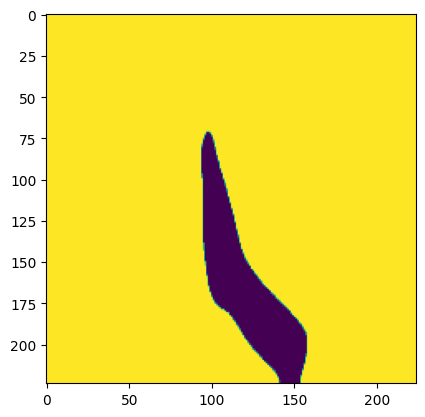

In [ ]:

plt.imshow(.5 - X_data[1050])
plt.grid(False)

 les fonctions  prépare les  données   et leurs étiquettes pour des tâches de classification d'image,
  en les formatant correctement pour des algorithmes de deep learning

In [ ]:

def process_image(path):
    img=Image.open(path)
    img=img.resize((224, 224))
    img=np.array(img)
    return img

def process_data(X_data, y_data):
    X_data = np.array(X_data, dtype = 'float32')
    y_data = np.array(y_data)
    y_data = to_categorical(y_data)
    return X_data, y_data


def walk_file_tree(relative_path):
    X_data = []
    y_data = []
    for directory, subdirectories, files in os.walk(relative_path):
        for file in files:
            if not file.startswith('.') and (not file.startswith('C_')):
               path = os.path.join(directory, file)
               gesture_name = gestures[file[0:2]]
               y_data.append(gestures_map[gesture_name])
               X_data.append(process_image(path))
        else:
            continue
    X_data, y_data = process_data(X_data, y_data)
    return X_data, y_data

In [ ]:
gestures = {'L_': 'L',
            'fi': 'Fist',
            'C_': 'C',
            'ok': 'Okay',
            'pa': 'Palm',
            'th': 'Thumb',
            'in': 'Index',
            'fm': 'Fist_Moved',
            'pm': 'Palm_Moved',
            'do': 'Down'
            }
gestures_map = {'Fist': 0,
                'L': 1,
                'Okay': 2,
                'Palm': 3,
                'Thumb': 4,
                'Index': 5,
                'C': 6,
                'Fist_Moved': 7,
                'Palm_Moved': 8,
                'Down': 9
                }


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)


In [ ]:
construction du model CNN en utilisant une combinaison de couches convolutionnelles, de pooling,
 de normalisation, et de couches denses pour traiter et classifier efficacement des images.

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

modelcnn1=models.Sequential()
modelcnn1.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation = 'relu', input_shape=(224, 224, 1)))
modelcnn1.add(layers.MaxPooling2D((2, 2)))
modelcnn1.add(BatchNormalization())
modelcnn1.add(layers.Conv2D (64, (3, 3), activation='relu'))
modelcnn1.add(layers.MaxPooling2D((2, 2)))
modelcnn1.add(BatchNormalization())
modelcnn1.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
modelcnn1.add(layers.MaxPooling2D((2, 2)))
modelcnn1.add(BatchNormalization())

modelcnn1.add(layers.Flatten())
modelcnn1.add(Dropout (0.5))
modelcnn1.add(layers.Dense (128, activation='relu'))
modelcnn1.add(layers. Dense(10, activation='softmax'))

In [ ]:
 configure le modèle de réseau de neurones en utilisant SGD comme optimiseur

In [ ]:
from tensorflow.keras.optimizers import SGD
opt = SGD(learning_rate=0.001, momentum =0.9)
modelcnn1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
préparation des ensembles de données pour
l`entraînement, encode les étiquettes en
 format approprié pour la classification, et entraîne un modèle
de deep learning sur ces données, tout en évaluant sa performance sur un ensemble de données de test

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

X_train = np.array(X_train)
X_test = np.array(X_test)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

hist1 = modelcnn1.fit(
    X_train, y_train_one_hot,
    epochs=15,0
    batch_size=256,
    verbose=1,
    validation_data=(X_test, y_test_one_hot)
)


Epoch 1/15
55/55 [==============================] - 482s 9s/step - loss: 0.9573 - accuracy: 0.6960 - val_loss: 0.9665 - val_accuracy: 0.6682
Epoch 2/15
55/55 [==============================] - 476s 9s/step - loss: 0.1221 - accuracy: 0.9671 - val_loss: 0.2644 - val_accuracy: 0.9273
Epoch 3/15
55/55 [==============================] - 482s 9s/step - loss: 0.0592 - accuracy: 0.9860 - val_loss: 0.0532 - val_accuracy: 0.9905
Epoch 4/15
55/55 [==============================] - 476s 9s/step - loss: 0.0375 - accuracy: 0.9924 - val_loss: 0.0251 - val_accuracy: 0.9965
Epoch 5/15
55/55 [==============================] - 488s 9s/step - loss: 0.0276 - accuracy: 0.9946 - val_loss: 0.0154 - val_accuracy: 0.9983
Epoch 6/15
55/55 [==============================] - 479s 9s/step - loss: 0.0239 - accuracy: 0.9949 - val_loss: 0.0098 - val_accuracy: 0.9987
Epoch 7/15
55/55 [==============================] - 481s 9s/step - loss: 0.0156 - accuracy: 0.9975 - val_loss: 0.0079 - val_accuracy: 0.9988
Epoch 8/15
55

 compilation du modèle avec l'optimiseur Adam et la perte (categorical_crossentropy pour la classification multi-classes)

In [ ]:
modelcnn1.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

Encodage des étiquettes

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Créer une instance de LabelEncoder
label_encoder = LabelEncoder()

# Adapter le label encoder aux étiquettes, puis les transformer
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [ ]:
from tensorflow.keras.utils import to_categorical

# Convertir les étiquettes entières en one-hot
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)


NameError: name 'y_train_encoded' is not defined

In [ ]:
entrainement du modèle

In [ ]:
hist4 = modelcnn1.fit(
    X_train, y_train_one_hot,  # données d'entrainement sont en format NumPy
    epochs=10,
    batch_size=64,
    verbose=1,
    validation_data=(X_test, y_test_one_hot)  #  données de validation sont aussi en format NumPy et one-hot
)


Epoch 1/10
219/219 [==============================] - 405s 2s/step - loss: 0.1634 - accuracy: 0.9666 - val_loss: 0.0098 - val_accuracy: 0.9975
Epoch 2/10
219/219 [==============================] - 376s 2s/step - loss: 0.0195 - accuracy: 0.9943 - val_loss: 0.0732 - val_accuracy: 0.9773
Epoch 3/10
219/219 [==============================] - 380s 2s/step - loss: 0.0361 - accuracy: 0.9915 - val_loss: 0.0277 - val_accuracy: 0.9953
Epoch 4/10
219/219 [==============================] - 377s 2s/step - loss: 0.0249 - accuracy: 0.9950 - val_loss: 0.0105 - val_accuracy: 0.9978
Epoch 5/10
219/219 [==============================] - 376s 2s/step - loss: 0.0140 - accuracy: 0.9966 - val_loss: 0.0089 - val_accuracy: 0.9988
Epoch 6/10
219/219 [==============================] - 380s 2s/step - loss: 0.0137 - accuracy: 0.9975 - val_loss: 0.0042 - val_accuracy: 0.9992
Epoch 7/10
219/219 [==============================] - 374s 2s/step - loss: 0.0103 - accuracy: 0.9980 - val_loss: 0.1367 - val_accuracy: 0.9910

EVALUATION DU MODÉLE

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Si y_test est encore en format de chaînes de caractères ou entiers non one-hot
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)  # utiliser le même encoder ou le même mapping que pour y_train
y_test_one_hot = to_categorical(y_test_encoded)

# Évaluation du modèle
[loss, accu] = modelcnn1.evaluate(X_test, y_test_one_hot, verbose=1)
print("Accuracy: " + str(accu))


188/188 [==============================] - 41s 217ms/step - loss: 0.0064 - accuracy: 0.9993
Accuracy: 0.9993333220481873


In [ ]:
modelcnn1.save("hand_gesture_Model.h5")

ARCHITECTURE MODÉLE KERAS

In [ ]:
modelcnn1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 55, 55, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 55, 55, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 26, 26, 64)        0         
 g2D)                                                            
                                                        

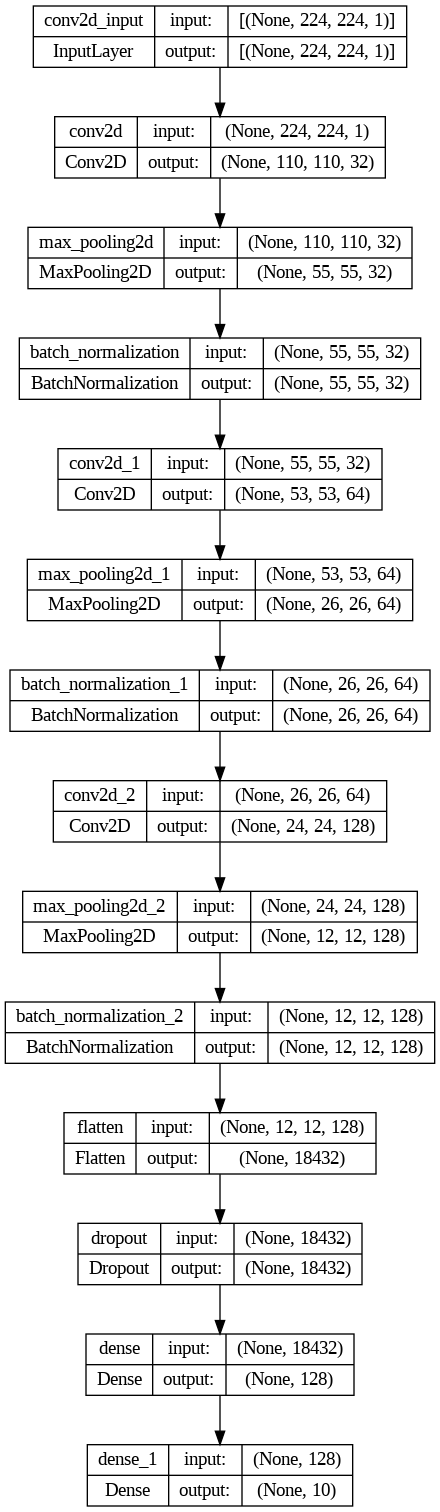

In [ ]:
from keras.utils import plot_model

plot_model(modelcnn1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

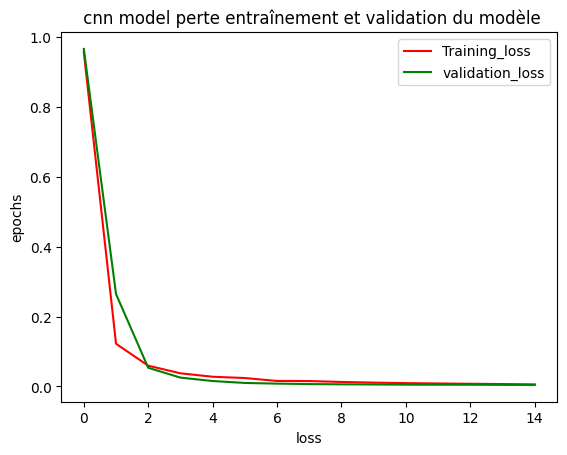

In [ ]:
plt.plot(hist1.history['loss'],'r', label='Training_loss')
plt.plot(hist1.history['val_loss'],'g', label= 'validation_loss')
plt.title(' cnn model perte entraînement et validation du modèle')
plt.ylabel('epochs')
plt.xlabel('loss')
plt.legend()
plt.show()

In [ ]:
[loss, accu] = modelcnn1.evaluate(X_test, y_test_one_hot, verbose=1)
print("Accuracy: " + str(accu))

188/188 [==============================] - 52s 279ms/step - loss: 0.0064 - accuracy: 0.9993
Accuracy: 0.9993333220481873


In [ ]:


def get_classification_metrics(X_test, y_test_one_hot):
  pred = modelcnn1.predict(X_test)
  pred = np.argmax(pred, axis=1)  # Numeric predictions
  y_true = np.argmax(y_test_one_hot, axis=1)
  cnf = confusion_matrix(y_true, pred)
  plt.figure(figsize=(10, 5))
  axs = sns.heatmap(sns, annot=True, fmt='g', cmap='Blues')
  axs.set_title('Confusion Matrix')
  axs.xaxis.set_ticklabels(['Palm', 'L', 'Fist', 'Fist moved', 'Thumb', 'Index', 'Ok', 'Palm moved', 'C', 'Down'])
  axs.yaxis.set_ticklabels(['Palm', 'L', 'Fist', 'Fist moved', 'Thumb', 'Index', 'Ok', 'Palm moved', 'C', 'Down'])
  plt.yticks(rotation=30)
  plt.show()


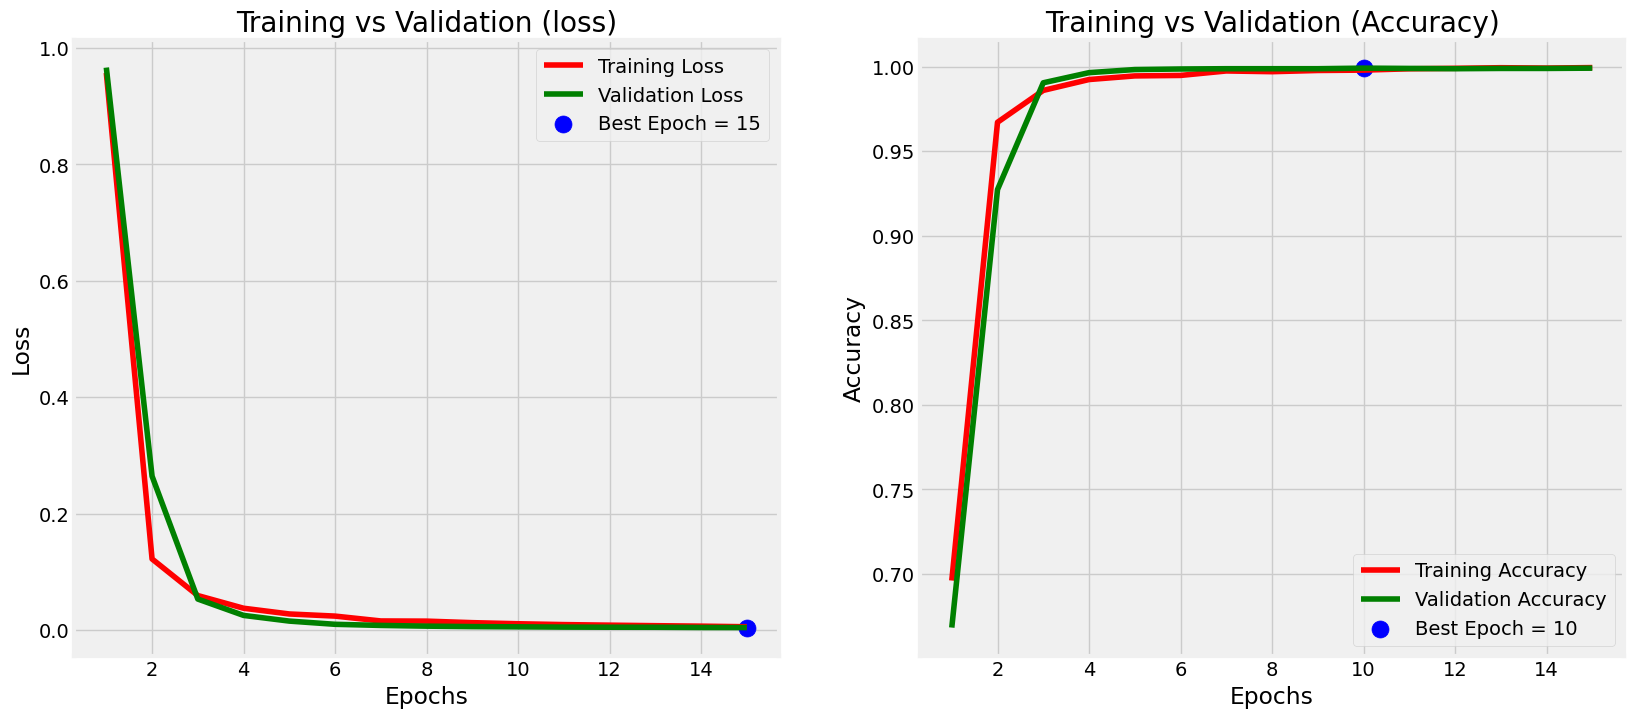

In [ ]:
train_acc = hist1.history['accuracy']
train_loss = hist1.history['loss']

val_acc = hist1.history['val_accuracy']
val_loss = hist1.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r', label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss +1 , val_lowest , s = 150 , c = 'blue' , label = loss_label)
plt.title('Training vs Validation (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r', label= 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s= 150 , c = 'blue' , label= acc_label)
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show();

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Model parameters
frame_sequence = 10  # Number of frames to include in each sequence
input_shape = (frame_sequence, 224, 224, 1)  # Update based on your dataset's frame size

# Define the model
model = Sequential([
    TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(BatchNormalization()),

    TimeDistributed(Conv2D(64, (3, 3), activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(BatchNormalization()),

    TimeDistributed(Conv2D(128, (3, 3), activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(BatchNormalization()),

    TimeDistributed(Flatten()),

    LSTM(128, return_sequences=True),
    LSTM(64),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Assuming 10 gesture classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 10, 222, 222, 32   320       
 ributed)                    )                                   
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 111, 111, 32   0         
 stributed)                  )                                   
                                                                 
 time_distributed_2 (TimeDi  (None, 10, 111, 111, 32   128       
 stributed)                  )                                   
                                                                 
 time_distributed_3 (TimeDi  (None, 10, 109, 109, 64   18496     
 stributed)                  )                                   
                                                                 
 time_distributed_4 (TimeDi  (None, 10, 54, 54, 64)    0

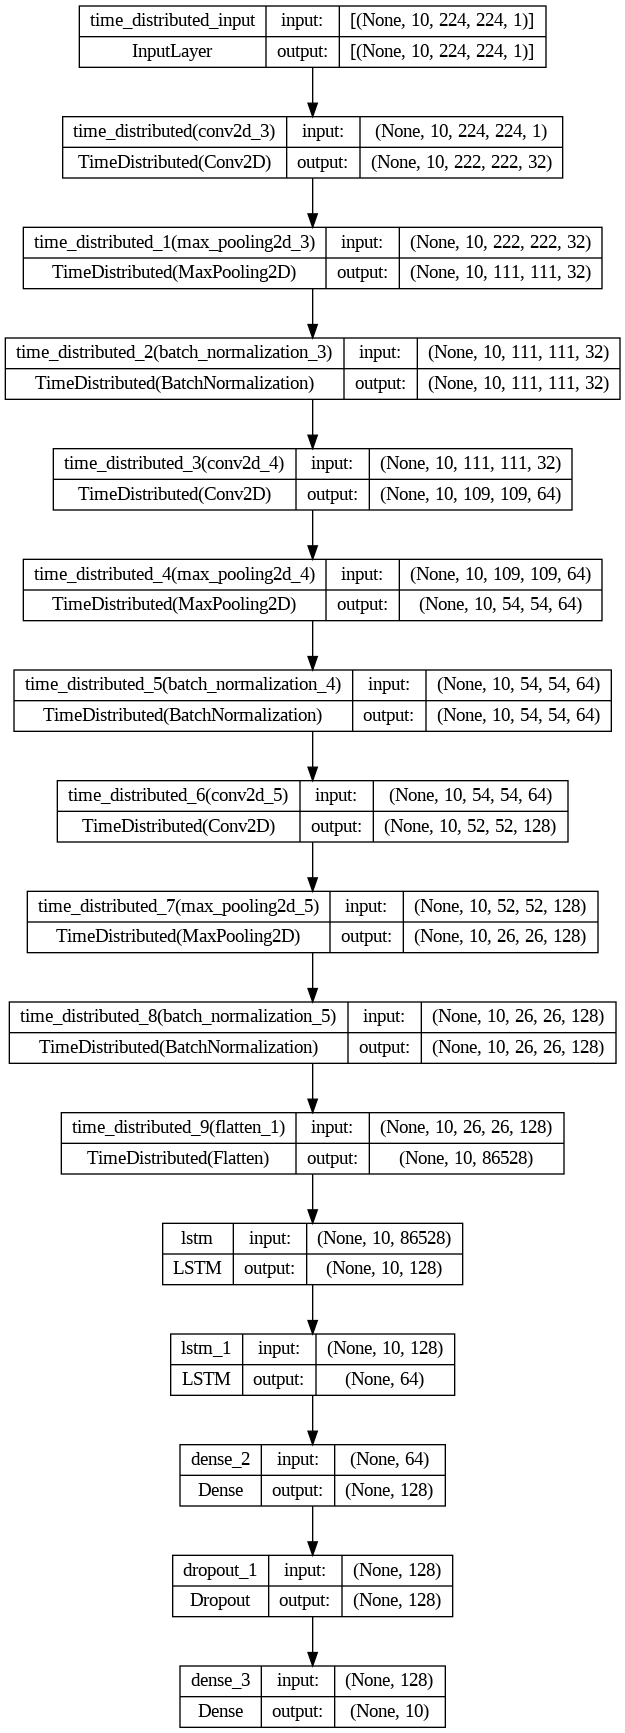

In [ ]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot_LSTM.png', show_shapes=True, show_layer_names=True)

In [ ]:
import cv2
import numpy as np
import os
import re

# Define gestures_map if it's not already defined
gestures_map = {
    1: 'Gesture1', 2: 'Gesture2', 3: 'Gesture3', 4: 'Gesture4',
    5: 'Gesture5', 6: 'Gesture6', 7: 'Gesture7', 8: 'Gesture8',
    9: 'Gesture9', 10: 'Gesture10'
}

X_data = []
y_data = []
root_dir = '/content/leapGestRecog/'

for directory, subdirectories, files in os.walk(root_dir):
    for file in files:
        if not file.startswith('.'):  # Corrected to use a string instead of bytes
            path = os.path.join(directory, file)
            gesture_name = re.search('(.*)frame_(\d{2})_(\d{2})_(\d{4})', os.path.basename(path))
            if gesture_name:
                gesture_id = int(gesture_name.group(3))  # Extracting the gesture number part
                if gesture_id in gestures_map:
                    y_data.append(gesture_id - 1)  # store numeric IDs, adjusted for zero-indexing
                    img = cv2.imread(path, cv2.IMREAD_COLOR)
                    img = cv2.flip(img, 1)  # Horizontal flip
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    blur = cv2.GaussianBlur(gray, (5, 5), 0)
                    ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                    thresh = cv2.resize(thresh, (224, 224))
                    X_data.append(thresh)

In [ ]:
def create_sequences(X_data, frame_sequence):
    X_seq = []
    for i in range(len(X_data) - frame_sequence + 1):
        X_seq.append(X_data[i:i+frame_sequence])
    return np.array(X_seq)

# Supposons que X_data est déjà prétraité et prêt à être transformé en séquences
X_data_seq = create_sequences(X_data, frame_sequence=10)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GRU, TimeDistributed, Dense, Flatten, Dropout

# Parameters
num_classes = 10  # Total number of gesture categories
frame_length = 224  # Dimensions of the input frame
frame_width = 224
sequence_length = 30  # Number of frames in a video sequence

# Model architecture
model = Sequential()

# CNN layers: Acting as feature extractors for each frame
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(sequence_length, frame_length, frame_width, 1)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))

# Flatten the output of the CNN before feeding it into the RNN layers
model.add(TimeDistributed(Flatten()))

# RNN layer: GRU units to capture temporal dynamics
model.add(GRU(64, return_sequences=False))  # Using one GRU layer with 64 units; adjust as necessary based on RAM availability

# Fully connected layers
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # Output layer for classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeD  (None, 30, 222, 222, 32   320       
 istributed)                 )                                   
                                                                 
 time_distributed_11 (TimeD  (None, 30, 111, 111, 32   0         
 istributed)                 )                                   
                                                                 
 time_distributed_12 (TimeD  (None, 30, 111, 111, 32   128       
 istributed)                 )                                   
                                                                 
 time_distributed_13 (TimeD  (None, 30, 109, 109, 64   18496     
 istributed)                 )                                   
                                                                 
 time_distributed_14 (TimeD  (None, 30, 54, 54, 64)   